In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})


In [2]:
exp_data = LorenzExp
initial_state = jnp.array([ -5, 0., 5])
initial_state = jnp.array([ -8,8,27.])
dt = 0.025
noise_var = 2.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

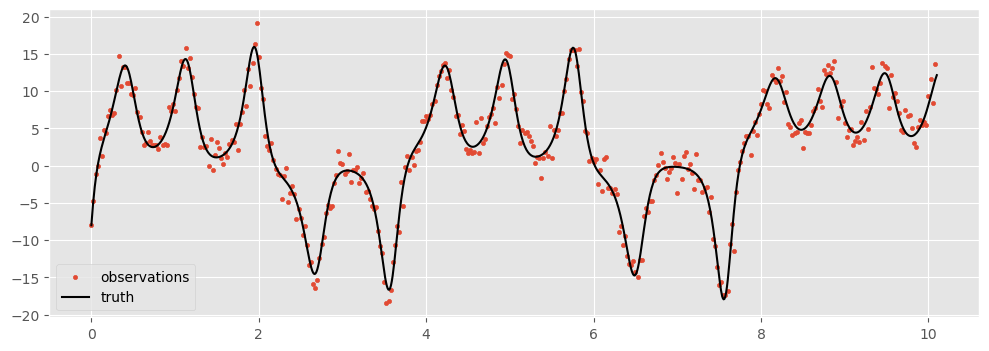

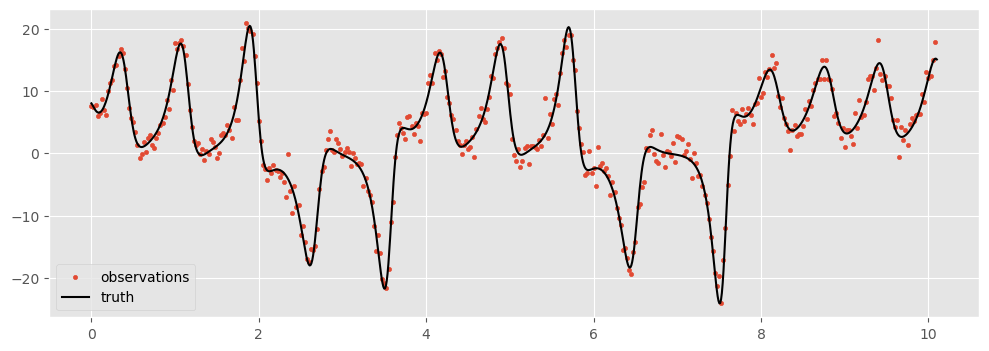

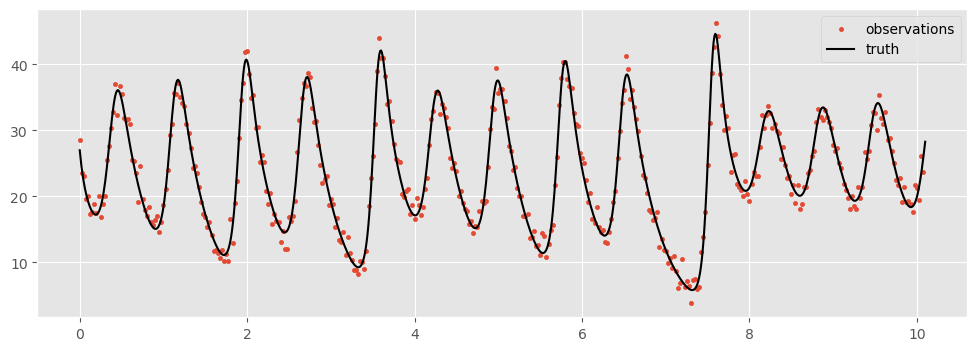

In [3]:
t_grid = jnp.linspace(t0,t1,1000)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth',c='black')
    plt.legend()
    plt.show()


In [4]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.5,alpha = 0.01)
    )
# sparsifier = pySindySparsifier(EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.1),bagging=True,n_models = 100))

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(2.14559367, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.06e+06, gradnorm = 3.427e+08, alpha = 4.167, improvement_ratio = 0.9958
Iteration 1, loss = 2.316e+05, gradnorm = 3.297e+08, alpha = 4.167, improvement_ratio = 0.7824
Iteration 2, loss = 4.172e+03, gradnorm = 1.143e+08, alpha = 3.472, improvement_ratio = 0.9873
Iteration 3, loss = 1.392e+03, gradnorm = 1.31e+07, alpha = 2.894, improvement_ratio = 0.9468
Iteration 4, loss = 1.296e+03, gradnorm = 3.238e+06, alpha = 2.894, improvement_ratio = 0.6072
Iteration 5, loss = 1.255e+03, gradnorm = 2.05e+06, alpha = 2.894, improvement_ratio = 0.6288
Iteration 100, loss = 1.223e+03, gradnorm = 0.1706, alpha = 0.0007912, improvement_ratio = 1.53
Line Search Failed!
Final Iteration Results
Iteration 106, loss = 1.223e+03, gradnorm = 0.09344, alpha = 6.328e+03, improvement_ratio = -667.0
Model after smooth warm start
(x)' = -11.747 1 + -7.983 x + 8.600 y + 0.924 z + 0.005 x^2 + 0.034 x y + -0.062 x z + -0.034 y^2 + 0.049 y z + -0.018 z^2
(y)' = 13.399 1 + 28.964 x + -1.833 y + -

In [5]:
model.print()

(x)' = -10.028 x + 10.099 y
(y)' = 27.958 x + -1.044 y + -0.997 x z
(z)' = -2.668 z + 0.997 x y


In [6]:
model.optimizer.solver_settings

LMSettings(max_iter=1000, atol_gradnorm=1e-08, cmin=0.05, line_search_increase_ratio=1.5, max_line_search_iterations=20, min_alpha=1e-16, max_alpha=100.0, init_alpha=5.0, step_adapt_multiplier=1.2, callback=None, print_every=100, track_iterates=False, show_progress=True, use_jit=True, no_tqdm=False)

In [7]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 190.686 + 72.76Matern(5,0.15)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.001,
sparsifier: STLSQ(alpha=0.01, threshold=0.5)
data_weight: 1.0
colloc_weight: 100000.0




In [9]:
expdata.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [10]:
model.print()

(x)' = -10.028 x + 10.099 y
(y)' = 27.958 x + -1.044 y + -0.997 x z
(z)' = -2.668 z + 0.997 x y


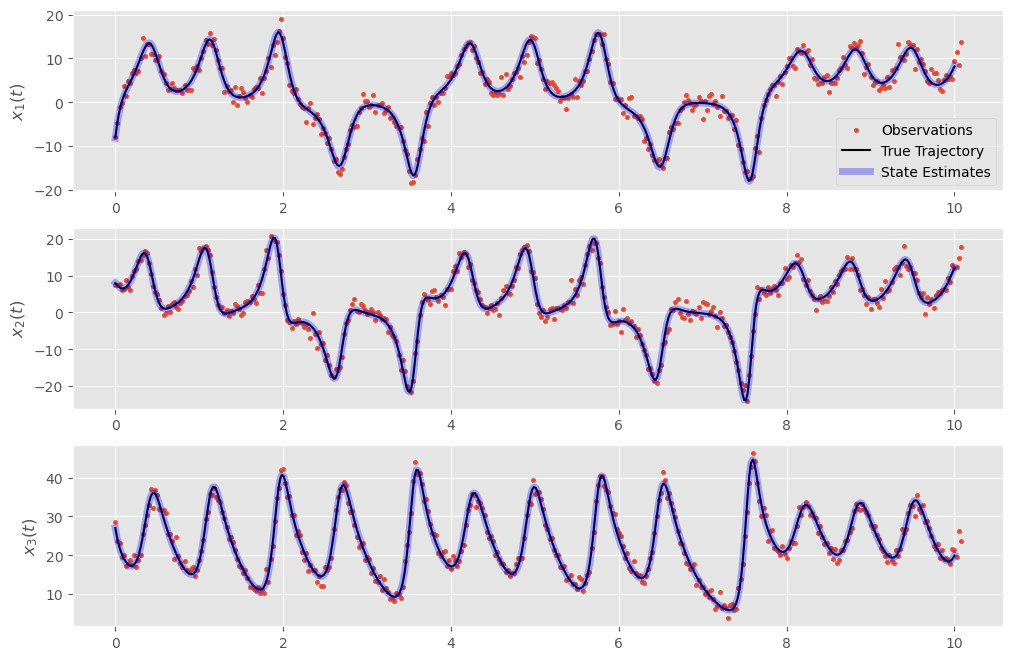

In [11]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
plt.figure(figsize=(12,8))
for dim in range(3):
    plt.subplot(3,1,dim+1)
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'Observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'True Trajectory',c='black')
    plt.plot(t_grid,state_preds[:,dim],label = 'State Estimates',c ='blue',alpha = 0.3,lw = 5)
    if dim ==0:
        plt.legend()
    plt.ylabel(f"$x_{dim+1}(t)$")
plt.savefig("figures/lorenz_prelim.pdf")

In [13]:
import numpy as np
import pysindy as ps

from pysindy import SmoothedFiniteDifference
from pysindy import STLSQ
from pysindy import EnsembleOptimizer


t_train = np.array(expdata.t_train)
x_train = np.array(expdata.x_train)
feature_library = ps.PolynomialLibrary(degree =2)

optimizer = EnsembleOptimizer(STLSQ(threshold = 0.5,alpha = 0.01),bagging=True,n_models = 200)
optimizer = STLSQ(threshold = 0.5,alpha = 0.01)
ps_model = ps.SINDy(
    differentiation_method=SmoothedFiniteDifference(),
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y","z"],
)
ps_model.fit(x_train,t_train)
ps_model.print()
print()
expdata.print()

(x)' = -1.345 1 + -9.418 x + 9.660 y
(y)' = 1.116 1 + 23.489 x + -0.884 x z
(z)' = -2.605 z + 0.977 x y

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


In [35]:
ps_model

,optimizer,EnsembleOptim...hreshold=0.5))
,feature_library,PolynomialLibrary()
,differentiation_method,SmoothedFiniteDifference()
,feature_names,"['x', 'y', ...]"
,t_default,1
,discrete_time,False
,degree,2
,include_interaction,True
,interaction_only,False
,include_bias,True
,order,'C'


In [ ]:
print(ps_model.feature_library._repr_html_())

<style>#sk-container-id-6 {
  /* Definition of color scheme common for light and dark mode */
  --sklearn-color-text: #000;
  --sklearn-color-text-muted: #666;
  --sklearn-color-line: gray;
  /* Definition of color scheme for unfitted estimators */
  --sklearn-color-unfitted-level-0: #fff5e6;
  --sklearn-color-unfitted-level-1: #f6e4d2;
  --sklearn-color-unfitted-level-2: #ffe0b3;
  --sklearn-color-unfitted-level-3: chocolate;
  /* Definition of color scheme for fitted estimators */
  --sklearn-color-fitted-level-0: #f0f8ff;
  --sklearn-color-fitted-level-1: #d4ebff;
  --sklearn-color-fitted-level-2: #b3dbfd;
  --sklearn-color-fitted-level-3: cornflowerblue;

  /* Specific color for light theme */
  --sklearn-color-text-on-default-background: var(--sg-text-color, var(--theme-code-foreground, var(--jp-content-font-color1, black)));
  --sklearn-color-background: var(--sg-background-color, var(--theme-background, var(--jp-layout-color0, white)));
  --sklearn-color-border-box: var(--sg-tex

In [34]:
# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]


In [ ]:
ode_lib = ps.WeakPDELibrary(
    function_library=feature_library,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=500,
)
optimizer = EnsembleOptimizer(
    STLSQ(threshold = 0.3,alpha = 0.005),
    bagging=True,
    n_models = 200)

# sr3_optimizer = ps.SR3(
#     reg_weight_lam=0.5,
#     regularizer="l0",
#     max_iter=100000,
#     normalize_columns=True,
#     tol=1e-1
# )
ps_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
ps_model.fit(x_train,t_train)
ps_model.print()


/ihme/homes/owlx/miniconda3/envs/jsindy/lib/python3.13/site-packages/pysindy/feature_library/weak_pde_library.py:177: UserWarning: is_uniform and periodic have been deprecated.in favor of differetiation_method and diff_kwargs.
  warnings.warn(
/ihme/homes/owlx/miniconda3/envs/jsindy/lib/python3.13/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


(x0)' = -1.522 1 + -9.742 x0 + 9.915 x1
(x1)' = 25.844 x0 + -0.417 x1 + -0.942 x0 x2
(x2)' = 3.894 1 + -2.845 x2 + 1.003 x0 x1


In [40]:
model.coefficients()

array([[-1.50243303, -9.71032182,  9.889654  ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 24.82117402,  0.        ,  0.        ,  0.        ,
         0.        , -0.92089562,  0.        ,  0.        ,  0.        ],
       [ 4.24931763,  0.        ,  0.        , -2.87899862,  0.        ,
         1.01067056,  0.        ,  0.        ,  0.        ,  0.        ]])